**mean and std of prob.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# For reproducibility
np.random.seed(42)

# Constants
alpha = 2.05
xmin = 0.35
xmax = 1000  # Maximum return

# Define the modified power law distribution
def modified_power_law(x):
    if x < 1:
        return (1 - xmin) * (alpha - 1) / xmin * (((1 - xmin) * x + xmin) / xmin) ** (-alpha)
    elif x >= 1 and x < xmax:
        return (alpha - 1) / xmin * (x / xmin) ** (-alpha)
    elif x == xmax:
        return xmax / xmin * (xmax / xmin) ** (-alpha)
    else:
        return 0

# Calculate the cumulative distribution function (CDF)
def cdf_power_law(x):
    result, _ = quad(modified_power_law, 0, x)
    return result

# Generate CDF values for a range of x
x_values = np.linspace(0, xmax, 10000)
cdf_values = np.array([cdf_power_law(x) for x in x_values])
cdf_values /= cdf_values[-1]  # Normalize

# Function to draw samples from the distribution
def draw_samples(n_samples):
    random_probs = np.random.rand(n_samples)
    samples = np.interp(random_probs, cdf_values, x_values)
    return samples


In [ ]:

# Simulation parameters
n_simulations = 10000  # 100000
n_sets = 20  # Number of different sets of samples
portfolio_sizes = range(1, 301)  # Portfolio sizes from 1 to 300

In [ ]:
from joblib import Parallel, delayed

# Draw a large number of samples only once
total_samples_needed = max(portfolio_sizes) * n_simulations * n_sets
all_samples = draw_samples(total_samples_needed)


In [ ]:

def run_simulation(portfolio_size, all_samples, n_simulations, n_sets):
    # Allocate an array for results of this portfolio size
    results = np.zeros(n_sets)

    # Slice the samples for the current portfolio size for all sets
    for set_index in range(n_sets):
        start = set_index * n_simulations * portfolio_size
        end = start + n_simulations * portfolio_size
        samples_for_set = all_samples[start:end].reshape((n_simulations, portfolio_size))

        # Compute the total return for each simulation
        total_returns = samples_for_set.sum(axis=1)

        # Calculate the frequency of doubling the investment
        results[set_index] = np.mean(total_returns >= 2 * portfolio_size)

    # Return the mean and standard deviation of the results for this portfolio size
    return np.mean(results), np.std(results)

# Use joblib's Parallel and delayed to run simulations in parallel
portfolio_results = Parallel(n_jobs=-1)(
    delayed(run_simulation)(size, all_samples, n_simulations, n_sets) for size in portfolio_sizes
)

# Extract mean frequencies and standard deviations into separate arrays
mean_frequencies, std_dev_frequencies = zip(*portfolio_results)

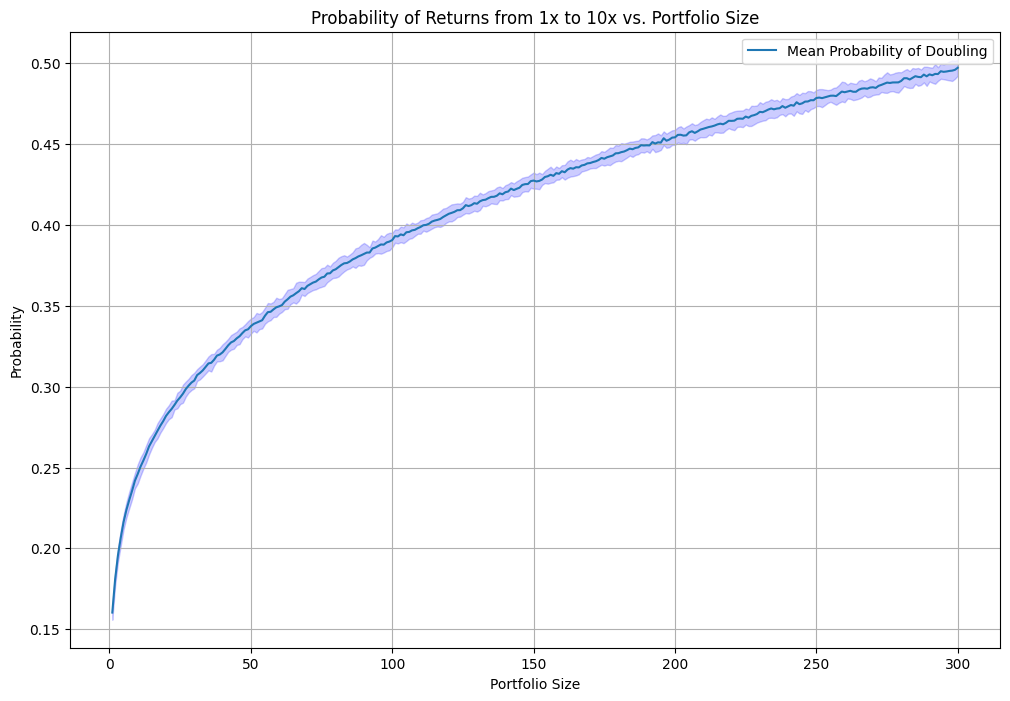

In [ ]:
# Convert the results to NumPy arrays for easier handling
mean_frequencies = np.array(mean_frequencies)
std_dev_frequencies = np.array(std_dev_frequencies)
portfolio_sizes = np.array(portfolio_sizes)

# Plotting
plt.figure(figsize=(12, 8))

# Plot the mean frequency of doubling the investment
plt.plot(portfolio_sizes, mean_frequencies, label='Mean Probability of Doubling')

# Add the standard deviation as a shaded region
plt.fill_between(portfolio_sizes,
                 mean_frequencies - std_dev_frequencies,
                 mean_frequencies + std_dev_frequencies,
                 color='blue', alpha=0.2)

plt.title('Probability of Returns from 1x to 10x vs. Portfolio Size')
plt.xlabel('Portfolio Size')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


**1-10x**

In [ ]:
def run_simulation(portfolio_size, all_samples, n_simulations, n_sets, multiples):
    # Allocate an array for results of this portfolio size for each multiple
    results = np.zeros((n_sets, len(multiples)))

    for set_index in range(n_sets):
        start = set_index * n_simulations * portfolio_size
        end = start + n_simulations * portfolio_size
        samples_for_set = all_samples[start:end].reshape((n_simulations, portfolio_size))

        # Compute the total return for each simulation
        total_returns = samples_for_set.sum(axis=1)

        # Calculate the frequency for each multiple
        for i, multiple in enumerate(multiples):
            results[set_index, i] = np.mean(total_returns >= multiple * portfolio_size)

    # Return the mean and standard deviation of the results for this portfolio size for each multiple
    return [np.mean(results[:, i]) for i in range(len(multiples))], [np.std(results[:, i]) for i in range(len(multiples))]

multiples = range(1, 11)  # 1x to 10x returns

# Use joblib's Parallel and delayed to run simulations in parallel for each portfolio size
portfolio_results = Parallel(n_jobs=-1)(
    delayed(run_simulation)(size, all_samples, n_simulations, n_sets, multiples) for size in portfolio_sizes
)

# Extract mean frequencies and standard deviations for each multiple into separate arrays
mean_frequencies = np.array([result[0] for result in portfolio_results])
std_dev_frequencies = np.array([result[1] for result in portfolio_results])




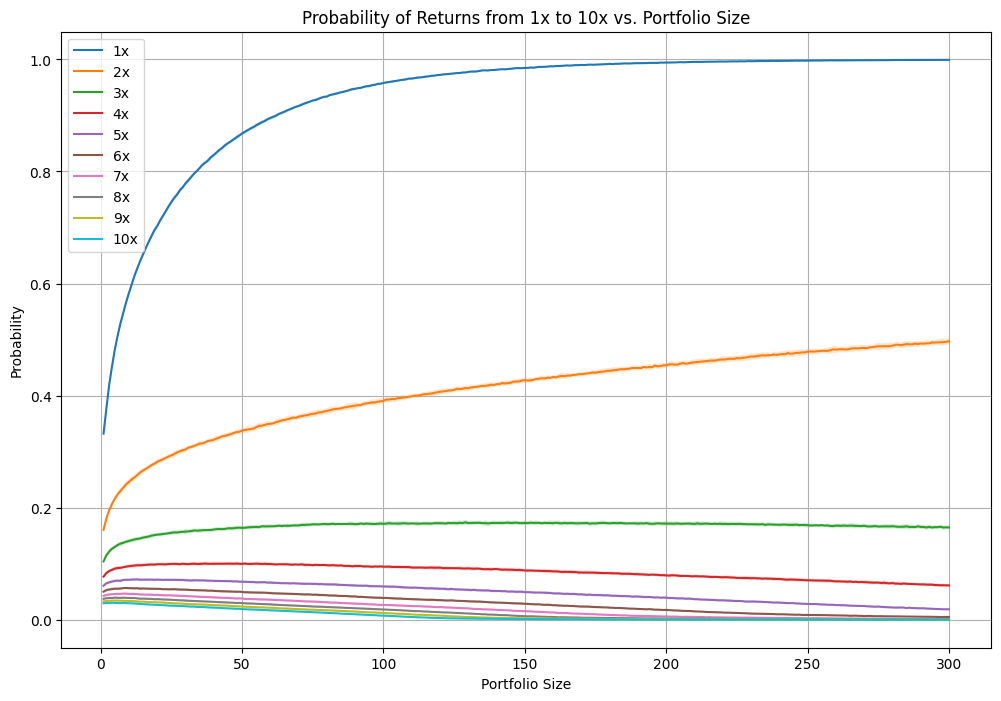

In [ ]:
plt.figure(figsize=(12, 8))

# Plot each multiple on the same graph
for i, multiple in enumerate(multiples):
    plt.plot(portfolio_sizes, mean_frequencies[:, i], label=f'{multiple}x')
    plt.fill_between(portfolio_sizes,
                     mean_frequencies[:, i] - std_dev_frequencies[:, i],
                     mean_frequencies[:, i] + std_dev_frequencies[:, i],
                     alpha=0.2)

plt.title('Probability of Returns from 1x to 10x vs. Portfolio Size')
plt.xlabel('Portfolio Size')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


**Impact of bounded return on investment (ROI)**

**Impact of decision quality**

**Impact of ticket sizing policy**

**Impact of follow-ons**